In [1]:
# Python Path non-sense
%load_ext autoreload
%autoreload 2

import sys
import os

# Remove the old path if it exists
#old_path = '/Users/maxw/projects/bayes_gsl'
#if old_path in sys.path:
#    sys.path.remove(old_path)

# remove any paths that contains 'bayes_gsl' in the sys.path
sys.path = [x for x in sys.path if 'bayes_gsl' not in x]
new_path = '/Users/maxw/projects/gsl-bnn/'
if new_path not in sys.path:
    sys.path.append(new_path)
""" 
# Append the new src directory to the system path
new_path = '/Users/maxw/projects/gsl-bnn/'
if new_path not in sys.path:
    sys.path.append(new_path)

# Confirm that the src directory is in the system path
print("Current sys.path:")
for path in sys.path:
    print(path)

"""
# Now try importing your module using the absolute path as a check
from src.models import dpg_bnn


In [2]:
"""
    Compare all models on NLL, BS, Error, ECE.
    Plot the calibration curves and the distribution of probabilities within each bin.

"""
import os
import pickle
import arviz
import matplotlib.pyplot as plt
import numpyro.infer
import seaborn as sns
from sklearn.calibration import calibration_curve
import numpy as np

import jax.numpy as jnp
import jax


from src import TMLR_TEXTWIDTH, TMLR_PLOT_DEPTH, FIGURES_PATH

from src.models import dpg_bnn, dpg_mimo_bnn, dpg_mimo_stochastic_head, pds_bnn
#from src.data import load_data
from src.metrics import compute_metrics

from src.config import num_samples_to_generate, w_init_scale, lam_init_scale, altered_prior
from experiments.iid_generalization.config import dpg_hyperparameters, pds_hyperparameters, dpg_mimo_hyperparameters, dpg_mimo_e_hyperparameters, experiment_settings
from src import NUM_BINS

In [3]:
from experiments.iid_generalization.config import dpg_hyperparameters, pds_hyperparameters, dpg_mimo_hyperparameters, dpg_mimo_e_hyperparameters, experiment_settings
models = {
        'dpg': (dpg_bnn, dpg_hyperparameters, f"dpg_D={dpg_hyperparameters['depth']}.pkl"),
        'pds': (pds_bnn, pds_hyperparameters, f"pds_D={dpg_hyperparameters['depth']}.pkl"),
        'dpg_mimo': (dpg_mimo_bnn, dpg_mimo_hyperparameters, f"dpg_mimo_D={dpg_mimo_hyperparameters['depth']}_C={dpg_mimo_hyperparameters['num_channels']}.pkl"),
        'dpg_mimo_e': (dpg_mimo_stochastic_head, dpg_mimo_e_hyperparameters, f"dpg_mimo_e_D={dpg_mimo_e_hyperparameters['mimo_base']['depth']}_C={dpg_mimo_e_hyperparameters['mimo_base']['num_channels']}_stoch_head_C={dpg_mimo_e_hyperparameters['num_stochastic_channels']}_D={dpg_mimo_e_hyperparameters['stochastic_head_depth']}.pkl")
    }

In [4]:
def display_metrics(metrics_dict):
    calibration_dict = metrics_dict['calibration_dict']
    print(f'Test Error: {1 - metrics_dict["accuracies"].mean():.5f} \pm {metrics_dict["accuracies"].std():.5f}')
    print(f'Test NLL: {-1 * metrics_dict["log_likelihoods"].mean():.3f} \pm {metrics_dict["log_likelihoods"].std():.3f}')
    print(f'Test BS: {metrics_dict["brier_scores"].mean():.5f} \pm {metrics_dict["brier_scores"].std():.5f}')
    print(f'Test ECE:{calibration_dict["ece"]:.5f}') 


In [5]:
# load the metrics for each model
model_metrics = {}
# Run experiments for each model
for name, (model, params, results_file) in models.items():
    results_path = os.path.join(experiment_settings['results_path'], results_file)
    print(f"\n**** {name} ****")
    if os.path.exists(results_path):
        print(f"Metrics found at {results_path}.")
        # Load results
        with open(results_path, 'rb') as f:
            results = pickle.load(f)
            #samples_key = 'samples' if name != 'dpg_mimo' else 'map point estimates'
            samples, metrics_dict = results['samples'], results['metrics']
            model_metrics[name] = metrics_dict
            display_metrics(metrics_dict)



**** dpg ****
Metrics found at /Users/maxw/projects/gsl-bnn/results/iid_generalization/dpg_D=200.pkl.
Test Error: 0.01574 \pm 0.01008
Test NLL: 10.333 \pm 5.378
Test BS: 0.01286 \pm 0.00716
Test ECE:0.00342

**** pds ****
Metrics found at /Users/maxw/projects/gsl-bnn/results/iid_generalization/pds_D=200.pkl.
Test Error: 0.01589 \pm 0.01026
Test NLL: 10.317 \pm 5.391
Test BS: 0.01285 \pm 0.00718
Test ECE:0.00375

**** dpg_mimo ****
Metrics found at /Users/maxw/projects/gsl-bnn/results/iid_generalization/dpg_mimo_D=200_C=4.pkl.
Test Error: 0.01416 \pm 0.00941
Test NLL: 9.191 \pm 5.155
Test BS: 0.01188 \pm 0.00665
Test ECE:0.00350

**** dpg_mimo_e ****
Metrics found at /Users/maxw/projects/gsl-bnn/results/iid_generalization/dpg_mimo_e_D=200_C=4_stoch_head_C=2_D=20.pkl.
Test Error: 0.01289 \pm 0.00823
Test NLL: 8.354 \pm 4.738
Test BS: 0.01065 \pm 0.00604
Test ECE:0.00240


hi


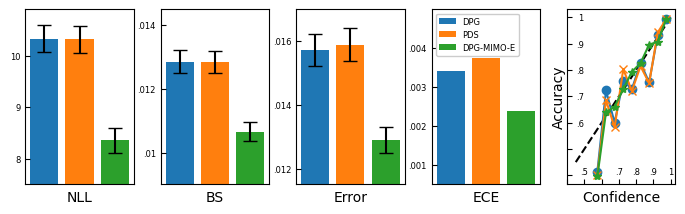

In [6]:
"""
    Make plot
"""
dpg_metrics = model_metrics['dpg']
pds_metrics = model_metrics['pds']
partial_stoch_metrics = model_metrics['dpg_mimo_e']

num_plots = 5
tick_fontsize = 6
label_fontsize = 10
fig, axes = plt.subplots(1, num_plots, figsize=(TMLR_TEXTWIDTH, TMLR_PLOT_DEPTH))
nll_ax, bs_ax, err_ax, ece_ax, cal_ax = axes


# first 4 plots: barplots (with stdv) of are the NLL, BS, Error, ECE for each model
stdv_scale = 1/20
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
# NLL
means = [-1*dpg_metrics['log_likelihoods'].mean(),
         -1*pds_metrics['log_likelihoods'].mean(),
         -1*partial_stoch_metrics['log_likelihoods'].mean()]
stdvs = np.array([dpg_metrics['log_likelihoods'].std(),
                  pds_metrics['log_likelihoods'].std(),
                  partial_stoch_metrics['log_likelihoods'].std()])
nll_ax.bar([0, 1, 2], means, yerr=stdv_scale*stdvs, capsize=5, color=colors)
nll_ax.set_xlabel('NLL', fontsize=label_fontsize)
nll_ax.set_ylim([7.5, 10.9])
nll_ax.set_yticks([8, 9, 10])
nll_ax.set_yticklabels([8, 9, 10], fontsize=tick_fontsize)

# BS
means = [dpg_metrics['brier_scores'].mean(),
         pds_metrics['brier_scores'].mean(),
         partial_stoch_metrics['brier_scores'].mean()]
stdvs = np.array([dpg_metrics['brier_scores'].std(),
                  pds_metrics['brier_scores'].std(),
                  partial_stoch_metrics['brier_scores'].std()])
bs_ax.clear()
bs_ax.bar([0, 1, 2], means, yerr=stdv_scale*stdvs, capsize=5, color=colors)
bs_ax.set_xlabel('BS', fontsize=label_fontsize)
#bs_ax.set_yscale('log')
bs_ax.set_ylim([.009, .0145])
bs_ax.set_yticks([1.0e-2, 1.2e-2, 1.4e-2])
bs_ax.set_yticklabels(['.01', '.012', '.014'], fontsize=tick_fontsize)

# Error
means = [1 - dpg_metrics['accuracies'].mean(),
         1 - pds_metrics['accuracies'].mean(),
         1 - partial_stoch_metrics['accuracies'].mean()]
stdvs = np.array([
    dpg_metrics['accuracies'].std(),
    pds_metrics['accuracies'].std(),
    partial_stoch_metrics['accuracies'].std()])
err_ax.clear()
err_ax.bar([0, 1, 2], means, yerr=stdv_scale*stdvs, capsize=5, color=colors)
err_ax.set_xlabel('Error', fontsize=label_fontsize)
#err_ax.set_yscale('log')
err_ax.set_ylim([.0115, .017])
err_ax.set_yticks([.012, .014, .016])
err_ax.set_yticklabels(['.012', '.014', '.016'], fontsize=tick_fontsize)

# ECE
ece_ax.clear()
ece_ax.bar([0, 1, 2],
           [dpg_metrics['calibration_dict']['ece'],
            pds_metrics['calibration_dict']['ece'],
            partial_stoch_metrics['calibration_dict']['ece']],
           #label=['dpg', 'pds', 'dpg-mimo-e'], 
           label=['DPG', 'PDS', 'DPG-MIMO-E'],
           color=colors)
ece_ax.set_xlabel('ECE', fontsize=label_fontsize)
ece_ax.set_yscale('linear')
ece_ax.set_ylim([.0005, .005])
ece_ax.set_yticks([.001, .002, .003, .004])
ece_ax.set_yticklabels(['.001', '.002', '.003', '.004'], fontsize=tick_fontsize)
ece_ax.legend(loc='upper left', fontsize=tick_fontsize, framealpha=1.0)
#ece_ax.set_ylim([.95, 1.05])

# last plot: calibration plot
cal_ax.clear()
cal_ax.plot([0.45, 1], [.45, 1], 'k--') #, label='Perfect') # Calibration')
# x is the center of the NUM_BINS uniform bins between 0.5 and 1
x = np.linspace(0.5, 1, NUM_BINS, endpoint=False) + 1/(4*NUM_BINS)
alpha=1.0
for calibration_dict, label, marker in \
        zip([dpg_metrics['calibration_dict'],
             pds_metrics['calibration_dict'],
             partial_stoch_metrics['calibration_dict']],
            ['base', 'pds', 'dpg-mimo-e'],
            ['o', 'x', '*']):
    bin_counts = calibration_dict['bin_counts']
    mask = bin_counts > 0
    cal_ax.plot(x[mask],
                calibration_dict['bin_acc'][mask],
                alpha=alpha,
                marker=marker,
                label=label)

cal_ax.tick_params(axis='y', direction='in')
# move y-label to right

cal_ax.set_yticks([.4, .5, .6, .7, .8, .9, 1])
cal_ax.set_yticklabels(['', '', '.6', '.7', '.8', '.9', '1'], fontsize=tick_fontsize)
cal_ax.set_xticks([.4, .5, .6, .7, .8, .9, 1])
cal_ax.set_xticklabels(['', '.5', '', '.7', '.8', '.9', '1'], fontsize=tick_fontsize)
cal_ax.tick_params(axis='both', which='major', pad=-12, direction='in')
cal_ax.set_ylabel('Accuracy', fontsize=label_fontsize, labelpad=1)
cal_ax.set_xlabel('Confidence', fontsize=label_fontsize, labelpad=4)
#cal_ax.legend(loc='upper left', fontsize=tick_fontsize, framealpha=1.0)

for ax in [nll_ax, bs_ax, err_ax, ece_ax]:
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.tick_params(axis='y', direction='in')
    #ax.set_xlabel('')
    # remove borders
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)

print('hi')
space = .25
plt.subplots_adjust(wspace=space, hspace=space, bottom=0.0, top=1, left=0.0, right=1.0) # SAVE FIG AND INSPECT BEFORE CHANGING!
plt.savefig(FIGURES_PATH + 'iid_generalization', dpi=1000, bbox_inches="tight", pad_inches=0.02)
plt.show(block=False)